In [561]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.integrate import quad
from scipy.differentiate import derivative
import scipy.integrate as integrate
from matplotlib import animation
from matplotlib.animation import PillowWriter
import patchworklib as pw
from sympy.codegen import Print

In [562]:
#time varying function for control

def f(t,args):
    T=args['T']
    return t/T #np.sin(np.pi * t / (2 * T))**2 #t/T

In [563]:
a = 0.1 #time-independent coupling constant
b = 1
c = 0.5
d = 0.3 #to avoid isc between first and second eigenenergy level
T = 1000 #time evolution interval
args = {'T': T}
t=0
t_list=np.linspace(0,T,1001) #time-stepping

In [564]:
#Static and Dynamic Hamiltonian
data=[[c,a,0],[a,-c,d],[0,d,0]]
H_static=qt.Qobj(data) #Static Hamiltonian
data1=[[-1,0,0],[0,1,0],[0,0,1*b]]
matrix1=qt.Qobj(data1)

def H_dynamic(b):
    return matrix1 #Dynamic Hamiltonian


In [565]:
#initial hamiltonian
H_0=H_static+(f(t,args)*H_dynamic(b))
eigenvalue,eigenvector=H_0.eigenstates()
psi0=eigenvector[0]

#total hamiltonian
H_total=[H_static,[H_dynamic(b),f]]

#Solving
final = qt.sesolve(H_total, psi0, t_list, args=args)


In [566]:
t_list[-1].item()

1000.0

In [567]:
discrete_gap=[]
for i,t in enumerate(t_list):
    def bandgap_func(t):
        f_value=f(t, args)
        H_tt = H_static + f_value * H_dynamic(b)
        eigenvalue1,eigenvector1=H_tt.eigenstates()
        gg=eigenvalue1[1]-eigenvalue1[0]
        return gg.item()
    discrete_gap.append(bandgap_func(t))
print('bandgap at (t=0) = ',bandgap_func(0))
print(f'bandgap at (t={t_list[-1].item()}) = ',bandgap_func(T))
print(len(discrete_gap))
print(discrete_gap[-1])

bandgap at (t=0) =  0.7833854724609888
bandgap at (t=1000.0) =  0.8794165127141249
1001
0.8794165127141249


In [568]:
print(dH_1_norm_squared(T))
print(bandgap_func(T))

1.4703345140538785e-06
0.8794165127141249


In [596]:
#Visualization
errors_fidelity = []
errors_norm = []
gap = []
ground=[]
first=[]
second=[]
error=[]

for i, t in enumerate(t_list):

    f_val = f(t, args)
    H_t = H_static + f_val * H_dynamic(b)

    # Get ideal eigenstates and energies
    evals, estates = H_t.eigenstates()
    g = evals[1]-evals[0]
    gap.append(g)

    #spectrum
    ground.append(evals[0])
    first.append(evals[1])
    second.append(evals[2])

    # Upper Bound for ERROR
    # first derivative
    m = 1
    def dH_1_norm(b):
        dH_1 = (H_dynamic(b)/T).full()
        return np.linalg.norm(dH_1,ord=2)

    def dH_1_norm_squared(t):
        # dH_10 = (H_dynamic(b)/T).full()
        # dH_11 = np.linalg.norm(dH_10,ord=2)
        dH_11=(1/T)**2
        f_value=f(t, args)
        H_tt = H_static + f_value * H_dynamic(b)
        eigenvalue1,eigenvector1=H_tt.eigenstates()
        g1=eigenvalue1[1]-eigenvalue1[0]
        gg=dH_11/g1**3
        return gg

    # def dH_1_norm_squared(t):
    #     f_value=f(t, args)
    #     H_tt = H_static + f_value * H_dynamic(b)
    #     eigenvalue1,eigenvector1=H_tt.eigenstates()
    #     g1=eigenvalue1[1]-eigenvalue1[0]
    #     return 1/g1**3

    def bandgap_func(t):
        f_value=f(t, args)
        H_tt = H_static + f_value * H_dynamic(b)
        eigenvalue1,eigenvector1=H_tt.eigenstates()
        gg=eigenvalue1[1]-eigenvalue1[0]
        return gg.item()

    # dH_2 = 0
    dH_11=(1/T)**2
    dH_2_norm=0

    ub_1 = m * dH_1_norm(b) * ((1 / bandgap_func(0) ** 2)+(1/bandgap_func(t) ** 2))
    ub_2 = (1 / T) * dH_2_norm / g ** 2
    # ub_3 = integrate.quad(dH_2_norm, 0, t)
    ub_4 = integrate.quad(dH_1_norm_squared, 0, t)
    # ub_44 = integrate.quad(bandgap_func,0,t)
    # # ub_3=0

    total_equation = ub_1 + ub_2  + (ub_4[0] * 7 * m * np.sqrt(m) )/T
    error.append(total_equation)

    # Calculate Error (using Fidelity): 1 - |<psi_ideal | psi_evolved>|^2
    fidelity = np.abs(estates[0].overlap(final.states[i])) ** 2
    errors_fidelity.append(1 - fidelity)

    #Norm
    diff_vector = estates[0] - final.states[i]
    diff_vector_converted = diff_vector.full()
    vector_distance = np.linalg.norm(diff_vector_converted,ord=2)
    errors_norm.append(vector_distance)


In [570]:
ub_1

np.float64(0.002922516220725784)

In [571]:
dH_1_norm_squared(0)

np.float64(2.0800484909865998e-06)

In [572]:
overrlapp=np.abs(estates[0].overlap(final.states[0]))**2
print(overrlapp)

0.032996969163651815


In [573]:
print('H_dot_norm=',dH_1_norm(b))
print('H_dynamic=',H_dynamic(b))
print('H_static=',H_static)
print('H_0=',H_0)

def H_00(t):
    return H_static+(f(t,args)*H_dynamic(b))
print('Initial Hamiltonian=',H_00(1000).full().real)
H_0_real= H_0.full().real

H_dot_norm= 0.001
H_dynamic= Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
H_static= Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.5  0.1  0. ]
 [ 0.1 -0.5  0.3]
 [ 0.   0.3  0. ]]
H_0= Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.5  0.1  0. ]
 [ 0.1 -0.5  0.3]
 [ 0.   0.3  0. ]]
Initial Hamiltonian= [[-0.5  0.1  0. ]
 [ 0.1  0.5  0.3]
 [ 0.   0.3  1. ]]


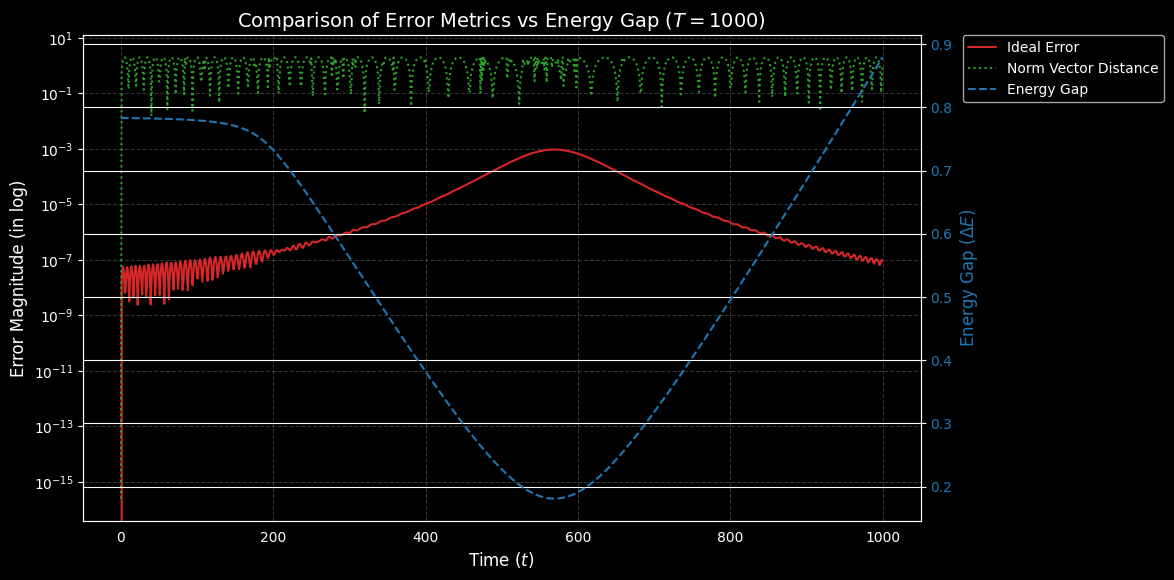

In [574]:
#Visulatization; Comparison of Error Metrics vs Energy Gap
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Time ($t$)', fontsize=12)
ax1.set_ylabel('Error Magnitude (in log)', fontsize=12)

# Plotting both error metrics
ax1.plot(t_list, errors_fidelity, color='tab:red', label='Ideal Error')
ax1.plot(t_list, errors_norm, color='tab:green', linestyle=':', label='Norm Vector Distance')
ax1.set_yscale('log') # Both metrics are best viewed on a log scale
ax1.grid(True, which="both", ls="--", alpha=0.2)

# Energy Gap on the second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel(r'Energy Gap ($\Delta E$)', color='tab:blue', fontsize=12)
ax2.plot(t_list, gap, color='tab:blue', linestyle='--', label='Energy Gap')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Final formatting
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.title(f'Comparison of Error Metrics vs Energy Gap ($T={T}$)', fontsize=14)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left',bbox_to_anchor=(1.05, 1.0),borderaxespad=0.)

# plt.savefig(f'/home/pravin/Desktop/Physik 2025/AQC Project/Comparison of Error Metrics vs Energy Gap (T={T}).png')
plt.show()

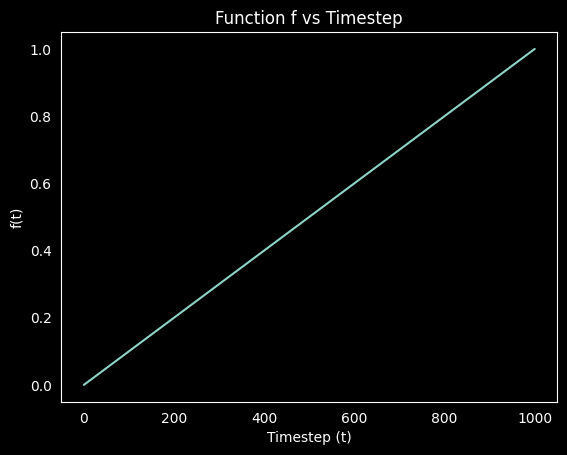

In [575]:
#for f vs T
f_values = [f(t, args) for t in t_list]
fidelity_values = [1 - err for err in errors_fidelity]
plt.figure()
plt.plot(t_list, f_values)
plt.title('Function f vs Timestep')
plt.xlabel('Timestep (t)')
plt.ylabel('f(t)')
plt.grid()
plt.show()

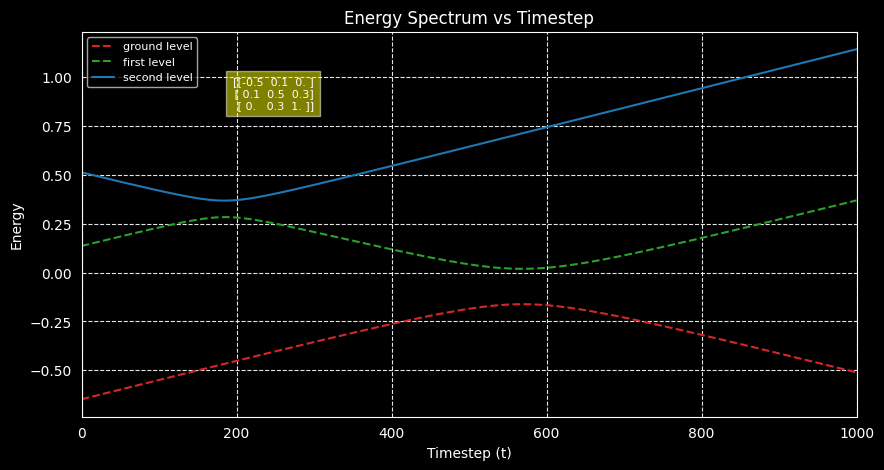

In [576]:

#Spectrum vs T
plt.figure(figsize=(10,5))
plt.plot(t_list, ground, color='tab:red', linestyle='--', label='ground level')
plt.plot(t_list, first, color='tab:green', linestyle='--', label='first level')
plt.plot(t_list, second, color='tab:blue', linestyle='-', label='second level')
plt.title('Energy Spectrum vs Timestep')
plt.xlabel('Timestep (t)')
plt.ylabel('Energy')
plt.text(300, 1.0, H_00(1000).full().real, fontsize=8,bbox=dict(facecolor='yellow', alpha=0.5),verticalalignment='top',
            horizontalalignment='right')
plt.legend(fontsize=8)
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid(linestyle='--',alpha=0.9)

# plt.savefig(f'/home/pravin/Desktop/Physik 2025/AQC Project/Energy_Spectrum/Energyplot(a={a},b={b},c={c},d={d}).png')

#for Fidelity vs Time
# plt.figure()
# plt.plot(t_list, fidelity_values, color='orange')
# plt.title('Fidelity vs Timestep')
# plt.xlabel('Timestep (t)')
# plt.ylabel('Fidelity')

plt.show()


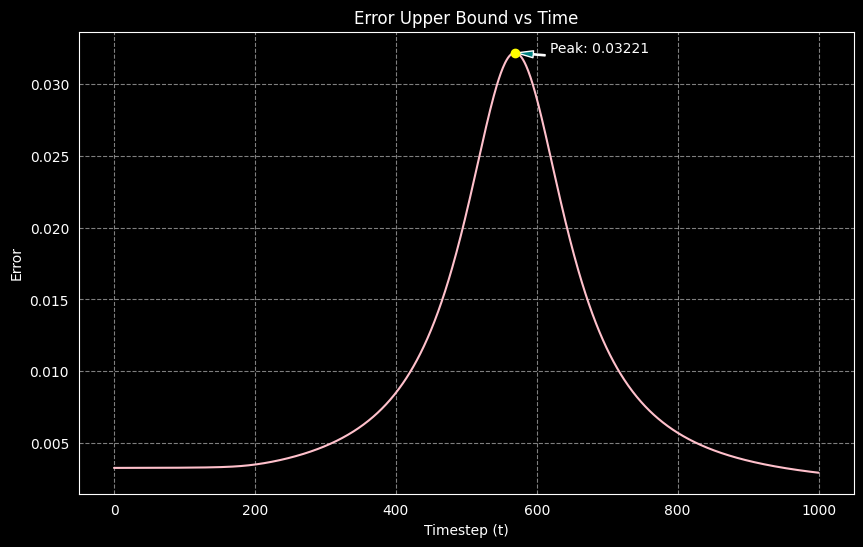

In [583]:
max_error=np.argmax(error)
time_at_error_peak=t_list[max_error]
error_value_at_peak=error[max_error]


plt.figure(figsize=(10,6))
plt.plot(t_list, error, color='pink')
plt.title('Error Upper Bound vs Time')
plt.xlabel('Timestep (t)')
plt.ylabel('Error')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
# plt.ylim(0, 0.01)
plt.scatter(time_at_error_peak, error_value_at_peak, color='yellow', zorder=5)
plt.annotate(f'Peak: {error_value_at_peak:.5f}',
             xy=(time_at_error_peak, error_value_at_peak),
             xytext=(time_at_error_peak + 50, error_value_at_peak),
             arrowprops=dict(fc='teal', shrink=0.05,width=0.9, headwidth=5))


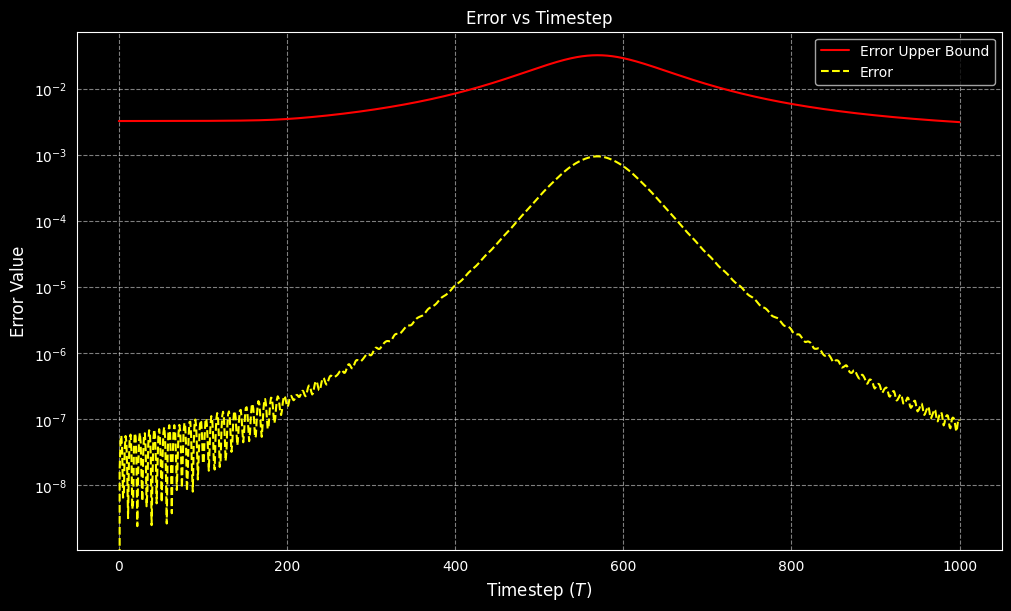

In [597]:
# plt.figure(figsize=(10,6))
fig, ax = plt.subplots(figsize=(10,6),layout='constrained')
Approximate_Error= ax.plot(t_list, error, color='red',label='Error Upper Bound')
Ideal_Error=ax.plot(t_list,errors_fidelity,'--', color='yellow',label='Error')
ax.set_ylabel('Error Value', fontsize=12)
ax.set_xlabel('Timestep ($T$)', fontsize=12)
ax.set_yscale('log')
ax.legend()
ax.set_title('Error vs Timestep')
plt.grid(linestyle='--',alpha=0.5)

# plt.savefig(f'/home/pravin/Desktop/Physik 2025/AQC Project/Error_Upper_Bound_Comparision(T={T}).png')


In [579]:
max_error=np.argmax(error)
max_error_1=np.argmax(errors_fidelity)
time_at_error_peak=t_list[max_error]
error_value_at_peak=errors_fidelity[max_error_1]
error_upper_bound_value_at_peak=error[max_error]
Difference_in_error=error_value_at_peak-error_upper_bound_value_at_peak

print('Peak Error Time: ',time_at_error_peak)
print('Error: ',error_value_at_peak)
print('Upper Bound Error: ',error_upper_bound_value_at_peak)
print('Difference between Error and EUB: ',Difference_in_error)


Peak Error Time:  569.0
Error:  0.0009511222310377709
Upper Bound Error:  0.032312425611176185
Difference between Error and EUB:  -0.031361303380138414


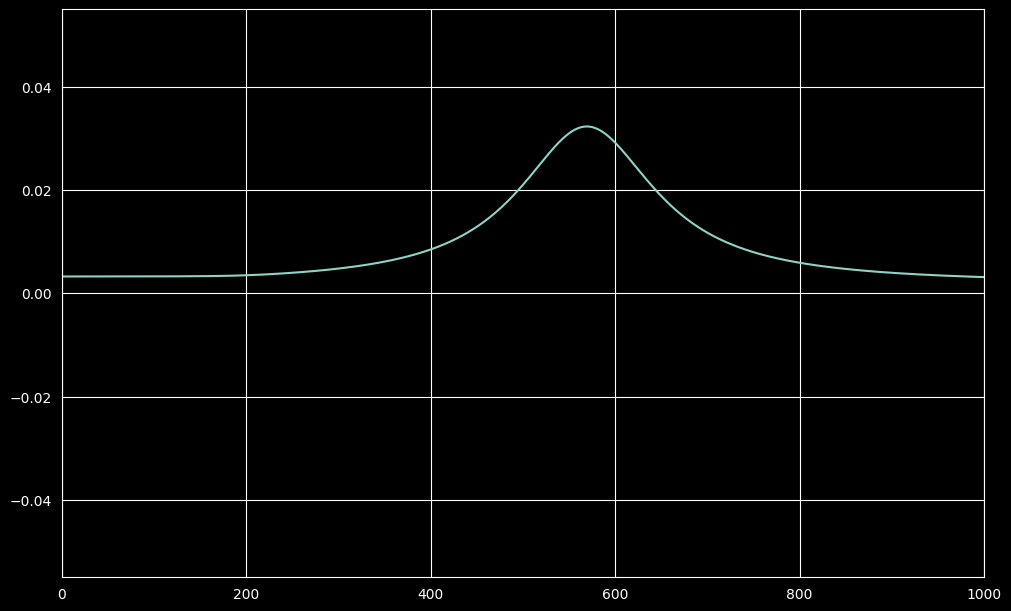

In [580]:
fig, ax = plt.subplots(figsize=(10,6),layout='constrained')
ln1, = plt.plot([],[])
time_text = ax.text(0.65, 0.95, '', fontsize=15,
                    bbox=dict(facecolor='white', edgecolor='black'),
                    transform=ax.transAxes)
ax.set_xlim(0,T)
# ax.set_ylim()

def animate(i):
    ln1.set_data(t_list, error)

ani = animation.FuncAnimation(fig, animate, frames=240, interval=50)
